# QHack2023 - Quantum Chemistry Challenge: BeH2

**Project:** VQE of 5 qubit $BeH_{2}$ model

**Description:** VQE is used to run a 5 qubit model of BeH2 and determine the ground state energy within chemical accuracy on a noiseless simulator. Noisy 6 qubit model results are also included at the end of this report. We have also evaluated the accuracy of this model for varying bond distance in the molecular geometry, indicating greater accuracy as bond distance increases, and an ideal  bond distance of approximately 1.3165 Angstrom. This works lays the groundwork for more efficient simulation on a real QPU, with as few as 5 qubits.

**Contributors:** Bartosz Tomsia, Grant Costa, Tyler Cowan

In [1]:
# Install necessary libraries in qBraid
# %pip install qiskit qiskit-nature[pyscf] pylatexenc --quiet

# Install necessary libraries in Colab
!pip install qiskit qiskit-nature[pyscf] pylatexenc -U --quiet

In [2]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # set white background
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

import numpy as np
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import BackendEstimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA, L_BFGS_B, GradientDescent
from qiskit.circuit.library import TwoLocal, EfficientSU2

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.settings import settings
settings.dict_aux_operators = True

## $BeH_{2}$ molecule definition

Bond length is a distance between each adjacent atom that we will define in [Angstrom](https://en.wikipedia.org/wiki/Angstrom) metric units. The bond length is an important factor in determining the strength of the bond between the atoms. The shorter the bond length, the stronger it is. This function will later be used to vary the bond distance and generate several different models to be evaluated using VQE.

In [3]:
# Molecule geometry
def get_beh2(distance):
  return [["Be", [ 0.0,    0.0,    0.0]], 
          ["H", [ 0.0,    0.0,   -distance]],
          ["H", [ 0.0,    0.0,   distance]]]

### Electronic structure problem

After specifying atomic coordinates (geometry), we need to initiate chemical driver (problem) according to the molecule total spin (multiplicity) and charge information and with one of available basis sets. For our calculations we have chosen [STO-3G](https://en.wikipedia.org/wiki/STO-nG_basis_sets).

After defining driver we can perform preliminary calculations and try to reduce the size of the problem to solve by using transformer that can reduce the problem to a configured active space.

In [4]:
def construct_problem(geometry, charge, multiplicity, basis="sto3g", freeze_core=True, remove_orbitals=None, maxiter=50):
    """
    Function for constructing molecule as Electronic structure problem with STO-3G basis set (default),
    reducing number of required qubits for calculation by freezing lowest electron orbitals and removing inactive orbitals
    and performing preliminary Quantum Chemistry calculation using PySCF    
    """
    molecule = Molecule(geometry=geometry,charge=charge, multiplicity=multiplicity)
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF)

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Freezing lowest electron orbitals (freeze_core=True) and removing inactive orbitals (integer list)
    freezeCoreTransformer = FreezeCoreTransformer(freeze_core=freeze_core,remove_orbitals=remove_orbitals)

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[freezeCoreTransformer])

    # The second quantized Hamiltonian (fermionic operator) of the reduced problem for electronic energy
    fermionic_ops = problem_reduced.second_q_ops().get('ElectronicEnergy')

    return problem_reduced, fermionic_ops, properties

#### Reduced problem

Transformer `FreezeCoreTransformer`, that we have chosen, allow to specify orbitals to be removed by means of two variables:
- `freeze_core` - enabled by default, the "core" orbitals will be determined automatically according to count_core_orbitals. These will then be made inactive and removed in the same fashion as in the [`ActiveSpaceTransformer`](https://qiskit.org/documentation/nature/locale/bn_BN/stubs/qiskit_nature.second_q.transformers.ActiveSpaceTransformer.html#activespacetransformer).
- `remove_orbitals` - unoccupied spatial orbitals can be removed by setting a list of indices. 

**Note:** Before doing that, we have ensured that orbitals to be removed are unoccupied ones.

Reducing problem results in qubit mapping that requires less qubits for algorithm definition.

Additionally in the bond distance section we cover the unreduced problem space results.

In [5]:
# Construct the problem using bond distance of 1.7A. Remove unoccupied orbitals 3 and 4 (of 7).

# IMPORTANT: Can change bond distance by updating 1.7 below for Be-H bond

problem_reduced, fermionic_ops, properties = construct_problem(geometry=get_beh2(1.7), charge=0, multiplicity=1, basis="sto3g", freeze_core=True, remove_orbitals=[3,4])

# Number of qubits after initial reduction
print(f"Fermionic operator has been mapped to {fermionic_ops.register_length} qubits")

Fermionic operator has been mapped to 8 qubits


In [6]:
# Electronic structure properties
print(properties)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.1.1
		Config:
			atom=Be 0.0 0.0 0.0;H 0.0 0.0 -1.7;H 0.0 0.0 1.7
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.991971273711595
		[0, 1] = -0.21012281570259572
		[0, 2] = -1.848360543034858e-16
		[0, 3] = -1.8483561024746623e-17
		[0, 4] = 1.6546510193377937e-31
		[0, 5] = -0.22831220797367524
		[0, 6] = -2.5992441246505917e-16
		[1, 0] = 0.030421514549834834
		[1, 1] = 0.6331724350282522
		[1, 2] = 6.618619043518678e-16
		[1, 3] = 9.805703082672633e-17
		[1, 4] = -2.0215509971383156e-30
		[1, 5] = 0.9804703496044782
		[1, 6] = 1.2466481344433012e-15
		[2, 0] = 2.7827855052623155e-33
		[2, 1] = 8.156844007249597e-32
		[2, 2] = -1.2809322310662367e-16
		[2, 3] = 1.0
		[2, 4] = -2.9566174298140426e-14
	

#### More reductions

We decided to find the simplest Hamiltonian possible, so that on noisy device the circuit is more shallow, so that there will be less noise to mitigate, which should prove useful in the NISQ era. In Qiskit tutorial [Simulating Molecules using VQE](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Problems) is information for $BeH_{2}$ molecule about possibility to use qubit tapering operations to reduce the number of required qubits to 7, without losing any chemical precision (being within 0.0016 [Hartree](https://en.wikipedia.org/wiki/Hartree) of the exact result).

In [29]:
# Function for a given problem maps fermionic operator to qubits and converts with Pauli operators reduction
def reduction(problem_reduced, fermionic_ops, mapper, two_qubit_reduction=False, z2symmetry_reduction=None):
  """
  This is where the qubit conversion is applied it will return the converter as well as the Hamiltonian, represented as
  a qubit operator
  
  mapper: one of the available in Qiskit Nature mappers: ParityMapper(), JordanWignerMapper(), BravyiKitaevMapper()
  two_qubit_reduction: If true a two_qubit reduction will be applied to the qubit converter
  z2symmetry_reduction: Any z2symmetry reduction passed in will be applied to the qubit converter
  """

  # Set the qubit converter with two qubit reduction to reduce the computational cost 
  converter = QubitConverter(mapper, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)

  # Compute the Hamitonian in qubit form
  qubit_op = converter.convert(fermionic_ops, num_particles=problem_reduced.num_particles)
  
  return converter, qubit_op

#### Qubit tapering with Z2 symmetries

Qubit tapering is a technique used in Quantum Computing to reduce the number of qubits needed to simulate a quantum system. This technique leverages the presence of certain symmetries in the system to identify a subset of qubits that can be eliminated without affecting the calculation results.

Z2 symmetry refers to a property of a quantum state that is invariant under the action of the Z2 group, which consists of two elements: 
- I - the identity element, represented by the number 1), 
- Pauli-Z gate - represented by the number -1.

In Qiskit Nature [`QubitConverter`](https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html) supports Z2 symmetry reduction.

In [8]:
from qiskit.opflow.primitive_ops import Z2Symmetries, PauliSumOp, TaperedPauliSumOp

# Reduce problem
converter, qubit_op = reduction(problem_reduced, fermionic_ops, mapper=BravyiKitaevMapper())

# Find Z2 symmetries for qubit tapering
z2symmetries = Z2Symmetries.find_Z2_symmetries(qubit_op)
print(z2symmetries)

Z2 symmetries:
Symmetries:
IIIIZIII
IZIZIZIZ
ZIIIIIII
Single-Qubit Pauli X:
IIIIXIII
IIIIIIIX
XIIIIIII
Cliffords:
0.7071067811865475 * IIIIZIII
+ 0.7071067811865475 * IIIIXIII
0.7071067811865475 * IZIZIZIZ
+ 0.7071067811865475 * IIIIIIIX
0.7071067811865475 * ZIIIIIII
+ 0.7071067811865475 * XIIIIIII
Qubit index:
[3, 0, 7]
Tapering values:
  - Possible values: [1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1], [-1, 1, 1], [-1, 1, -1], [-1, -1, 1], [-1, -1, -1]


#### Reduction to 5-qubit hamiltonian

In [9]:
# Reduction of the problem to 5-qubit hamiltonian with use of Z2 symmetry reduction for values [1, 1, 1]
converter, qubit_op = reduction(problem_reduced, fermionic_ops, mapper=BravyiKitaevMapper(), z2symmetry_reduction=[1,1,1])
print(qubit_op)

-2.1251355411798682 * IIIII
+ 0.09658465993433141 * ZIZZI
- 0.001962891713328568 * IIIYY
+ 0.001962891713328568 * ZIZYY
+ 0.0785764634748828 * ZIZZZ
- 0.008851618031181523 * ZIZZX
+ 0.008851618031181523 * IIIZX
- 0.08569031782260991 * IIIZI
- 0.2187311583739367 * IIIZZ
+ 0.09658465993433146 * IIZII
- 0.001962891713328567 * YYXII
+ 0.001962891713328567 * XYYII
+ 0.07857646347488272 * IZZII
- 0.008851618031181528 * IXZII
+ 0.008851618031181528 * ZXIII
- 0.08569031782260991 * ZIIII
- 0.21873115837393672 * ZZIII
+ 0.11989911663595663 * IIIIZ
- 0.0076937912107231336 * IIIIX
+ 0.0076937912107231336 * ZIZIX
+ 0.2945029108928997 * ZIZII
+ 0.15347080904163074 * ZIZIZ
+ 0.00514074256442611 * ZIZXX
- 0.00514074256442611 * IIIXX
- 0.009110140443095317 * ZIZXZ
+ 0.03676479981578867 * IIIXI
- 0.027654659372693353 * IIIXZ
+ 0.18603220836053874 * ZIIZI
- 0.003900690257491414 * IIZYY
+ 0.003900690257491414 * ZIIYY
+ 0.03868205812444731 * IZXIZ
- 0.03868205812444731 * IIXIZ
- 0.03868205812444731 * IZXII

#### Calculate reference ground state energy

We need to compare the calculated values with reference value (exact ground state energy), so in function `simulated_results` we will employ the Unitary Couple Cluster (UCCSD) ansatz as our variational form and the Sequential Least Squares Programming (SLSQP) optimizer. This will later be compared to our results using a 5 qubit model for BeH2.

In [10]:
# Get reference solution by simulating on statevector simulated quantum instance and ansatz
def simulated_results(problem, converter, maxiter=50): 
  vqe_factory = VQEUCCFactory(quantum_instance=Aer.get_backend("aer_simulator_statevector"),optimizer=SLSQP(maxiter=maxiter),
                              ansatz=UCC(excitations='sd') # UCC"SD" ansatz
                            )
  solver = GroundStateEigensolver(converter, vqe_factory)    
  reference_value = solver.solve(problem).total_energies[0]
  ansatz=vqe_factory.ansatz
  return reference_value, ansatz

In [30]:
algorithm_globals.random_seed = 1024

# Calculate ground state energy on simulated backend
reference_value, ansatz = simulated_results(problem_reduced, converter)
print("Reference value:", reference_value)

Reference value: (-15.466648510480418+0j)


### Variational Quantum Eigensolver (VQE)

In quantum computing, the Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm used to find the ground state energy of a given Hamiltonian. The VQE algorithm involves preparing a quantum state using a parametrized quantum circuit called an `ansatz`, and then optimizing the parameters of the circuit to minimize the energy of the Hamiltonian.

The choice of the ansatz is an important factor in the VQE algorithm, as it determines the expressiveness of the circuit and the computational resources required to run the algorithm. An ansatz with more parameters and deeper circuit depth (like UCCSD) can represent more complex quantum states, but requires more computational resources to simulate and run on a quantum device.

Due to the limitations of current NISQ (Noisy Intermediate-Scale Quantum) devices, it is often more feasible to use shallower circuits with fewer parameters in the VQE algorithm. This is because the higher error rates and limited coherence times of NISQ devices can make it challenging to simulate and execute deep circuits accurately.

A common strategy in VQE is to start with a simple, shallow ansatz and gradually increase its complexity until the desired accuracy is achieved. This approach allows the algorithm to be run on NISQ devices while still exploring a wide range of quantum states.

#### Parametrized quantum circuit (ansatz)

In [38]:
from qiskit.circuit import ParameterVector

def create_ansatz(n_qubit, depth):

  custom_ansatz = QuantumCircuit(n_qubit)
  theta = ParameterVector('θ', n_qubit*depth*4)# rx +6)

  for d in range(depth):
    for i in range(n_qubit):
      custom_ansatz.ry(theta[2*i+2*n_qubit*d], i)
      custom_ansatz.rz(theta[2*i+1+2*n_qubit*d], i)
    custom_ansatz.barrier()
    for i in range(n_qubit//2):
      custom_ansatz.cx(2*i, 2*i+1)
    for i in range(n_qubit//2-1):
      custom_ansatz.cx(2*i+1, 2*i+2)
    custom_ansatz.cx(n_qubit-1, 0)
    custom_ansatz.barrier()
    for i in range(n_qubit):
      custom_ansatz.ry(theta[2*i+2*n_qubit*depth], i)
      custom_ansatz.rz(theta[2*i+1+2*n_qubit*depth], i)

  print("Circuit depth:", custom_ansatz.depth())
  custom_ansatz.draw('mpl')
  return custom_ansatz

For comparison, we can check how big was initial ansatz created with UCCSD method. We used the UCC and UCCSD ansatzes initially, but found they were intractable for classical simulatiion using our personal computers due to their greater circuit depth, necessitating a custom ansatz seen above.

In [40]:
# UCCSD circuit depth
print("UCCSD circuit depth:", ansatz.decompose(reps=3).depth())

UCCSD circuit depth: 609


## Custom VQE Class

We have defined a custom VQE class to orchestrate the ansatz, classical optimizers, initial point, callback, and final result.

The objective function that is called by the optimizer uses the estimator to run the given ansatz and given hamiltonian for the input parameters. The results of the job are then interpreted and sent to a callback function for further processing/logging.



In [31]:
from qiskit.algorithms import MinimumEigensolver, VQEResult, MinimumEigensolverResult

params_history = []

class CustomVQE(MinimumEigensolver):

    def __init__(self, estimator, circuit, optimizer, problem=None, callback=None, aux_operators=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._problem = problem
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, initial_point=None):

        # Define objective function to classically minimize over
        def objective(x):
            
            # Execute job with estimator primitive
            x = list(x)
            job = self._estimator.run([self._circuit], [operators], [x])

            # Add parameters to history
            params_history.append(x)

            # Get results from jobs
            est_result = job.result()
            
            # Get the measured energy value
            value = est_result.values[0]
            
            # Interpret results (add nuclear repulsion energy)
            sol = MinimumEigensolverResult()
            sol.eigenvalue = value
            sol = self._problem.interpret(sol).total_energies[0]

            # Save result information using callback function
            if self._callback is not None:
                self._callback(np.real(sol))
            return np.real(sol)

        # Select an initial point for parametrized circuit
        if initial_point is None:
            initial_point = np.random.rand(self._circuit.num_parameters)
        
        #print(self._initial_point)
        res = self._optimizer.minimize(objective, x0=initial_point)#, bounds=[-18.5,-16])#self._initial_point)

        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_value = res.fun
        result.optimal_parameters = res.x

        return result, params_history

SLSQP was chosen because we found it to converge faster than SPSA on a noiseless simulator and the runtime seemed faster than L_BFGS_B.

Backend used was a standard statevector simulation with the efficient custom ansatz made above.

We also ran our 6 qubit VQE model on several fake noisy backends provided by Qiskit. 

In [15]:
# AerEstimator need to be imported before estimator initialization
from qiskit_aer.primitives import Estimator as AerEstimator

In [16]:
# Define instance of Aer Estimator primitive for faster runs
custom_ansatz = create_ansatz(5,4)
estimator = AerEstimator([custom_ansatz], [qubit_op], backend_options={'method':'statevector'}, run_options={'shots':None}, approximation=True)

# Define a simple callback function returning interpreted eigenvalue
intermediate_info = []
def callback(value):
        # Overwrites the same line when printing
        display("Energy: {}".format(value))
        clear_output(wait=True)
        intermediate_info.append(value)

# Choose optimizer and set maximum number of iterations
optimizer = SLSQP(maxiter=500)

# Calculate for deterministic and 
initial_point = np.ones(custom_ansatz.num_parameters) * np.pi/4

Circuit depth: 24


The intial point chosen for our VQE is pi/4 for all of our parameters. We chose this because it is a realistic arbitrary angle to use for the rotation gates at the beginning of the VQE. Randomization was also tried as an initial point but we saw it had no effect on our results.

In [17]:
# Plots graph with expectation values results for reach function evaluation
def plot_graph(energy, reference_value, molecule, color="tab:blue", save=None):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(energy, label="Estimator VQE {}".format(molecule),color = color)
    plt.grid()
    plt.axhline(y=reference_value.real-0.0016, color="tab:green", ls="--", lw=2, label="-0.0016 Hartree")
    #plt.text(x=0,y=0.0005+reference_value.real+0.0016,s='+0.0016',color="green")
    plt.text(x=0,y=0.0005+reference_value.real+0.0016,s='Chemical accuracy',color="green")
    plt.axhline(y=reference_value.real, color="tab:red", ls="--", label="Target")
    plt.axhline(y=reference_value.real+0.0016, color="tab:green", ls="--", lw=2, label="+0.0016 Hartree")
    #plt.text(x=0,y=0.0005+reference_value.real-0.0016,s='-0.0016',color="green")
    plt.legend(loc="best")
    plt.xlabel("# Evaluations")
    plt.ylabel("Energy [Hartree]")
    plt.title("VQE energy")
    if save:
      plt.savefig(fname=f"{molecule}_Energy.png", bbox_inches='tight', transparent=False)
    plt.show()

By using our CustomVQE class from above, and running the compute_minimum_eigenvalue function, the objective function will be minimized, which in this case is the resulting eigenenergy of the molecule.


In [18]:
%%time
# Setup VQE algorithm
intermediate_info = []
custom_vqe = CustomVQE(estimator, custom_ansatz, optimizer, problem_reduced, callback=callback)

# Run the custom VQE function and monitor execution time
result, params_history = custom_vqe.compute_minimum_eigenvalue(qubit_op, initial_point=initial_point)

CPU times: user 2min 17s, sys: 6.47 s, total: 2min 23s
Wall time: 2min 51s


Relative error: 0.0078 %  =  0.0012039322219656867 Ha


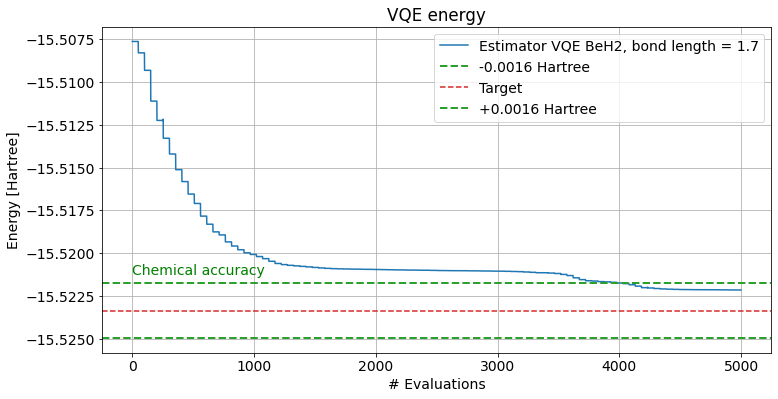

Optimal parameters: [ 8.52178281e-01  2.21222695e+00  1.36686708e+00  1.42889200e+00
  1.58719253e+00  1.01079468e-01  1.19281453e+00  6.67422949e-02
  1.83518732e+00  4.18488563e-01  1.46168618e+00  1.54014674e+00
  1.43038087e-01  5.67119830e-01  1.74121591e+00  3.25376156e-02
  1.25194603e+00  2.50029504e-02  3.10103525e-01  9.69752278e-01
 -1.07805683e-01  2.83990259e+00  6.15313679e-01  1.12560171e-01
  9.12073794e-01  2.22029964e+00  1.55004759e+00 -3.65480642e-02
  1.84442406e+00  8.30384118e-01  1.85293465e+00 -1.72256392e+00
  7.12971149e-03  4.01585250e-01  9.66291069e-01  1.11716661e+00
  1.60154065e+00  1.39872459e-01  1.51009696e-02  6.17138573e-01
  1.63861440e+00  1.65937696e-01  1.27180568e+00  1.14805424e+00
 -1.12279107e-01  1.13736690e+00  1.56990245e+00  1.33039074e+00
 -2.26329652e-03  1.67630279e+00]


In [19]:
# Plot Graph BeH2
energy = intermediate_info.copy()
print("Relative error:", np.round(np.abs((energy[-1].real-reference_value)/reference_value*100),4), "%", " = ", np.abs(energy[-1].real-reference_value), "Ha")

plot_graph(energy[-5000:], reference_value, molecule=f"BeH2, bond length = 1.7", color="tab:blue", save=None)
print("Optimal parameters:", result.optimal_parameters)

As can be seen in the above plot, **chemical accuracy** of the ground state energy (within .0016 Hartree) has been achieved using a 5 qubit model on a noiseless simulator. This is an important metric we use to benchmark the success of our VQE, which is defined as the accuracy needed in order to make reliable predictions about chemical behavior. 

# Appendix & Further Analysis

## Bond Distance Data Collection

We seek to characterize the relationship between the model's bond distance and the accuracy of the VQE, below. 

In [20]:
# Define a simple callback function returning interpreted eigenvalue
intermediate_info = []
def callback(value):
        # Overwrites the same line when printing
        # display("Energy: {}".format(value))
        # clear_output(wait=True)
        intermediate_info.append(value)

# Choose optimizer and set maximum number of iterations
optimizer = SLSQP(maxiter=500)

custom_ansatz = create_ansatz(5,4)

distances = np.linspace(0.5, 1.9, 15)
vqe_energies = [] 

for dist in distances:
  problem_reduced, fermionic_ops, properties = construct_problem(geometry=get_beh2(dist), charge=0, multiplicity=1, basis="sto3g", freeze_core=True, remove_orbitals=[3,4])

  # Reduce problem
  converter, qubit_op = reduction(problem_reduced, fermionic_ops, mapper=BravyiKitaevMapper())

  # Find Z2 symmetries for qubit tapering
  z2symmetries = Z2Symmetries.find_Z2_symmetries(qubit_op)
  print([1] * len(z2symmetries.sq_list))
  converter, qubit_op = reduction(problem_reduced, fermionic_ops, mapper=BravyiKitaevMapper(), z2symmetry_reduction=[1] * len(z2symmetries.sq_list))

  # Setup VQE algorithm
  intermediate_info = []
  estimator = AerEstimator([custom_ansatz], [qubit_op], backend_options={'method':'statevector'}, run_options={'shots':None}, approximation=True)

  custom_vqe = CustomVQE(estimator, custom_ansatz, optimizer, problem_reduced, callback=callback)

  # Calculate for deterministic and 
  initial_point = np.ones(custom_ansatz.num_parameters) * np.pi/4

  # Run the custom VQE function and monitor execution time
  result, params_history = custom_vqe.compute_minimum_eigenvalue(qubit_op, initial_point=initial_point)
  vqe_energies.append(intermediate_info[-1])
  print("Distance:", dist, "->", intermediate_info[-1])

Circuit depth: 24
[1, 1, 1]
Distance: 0.5 -> -13.663832262592285
[1, 1, 1]
Distance: 0.6 -> -14.389421030635935
[1, 1, 1]
Distance: 0.7 -> -14.859382564623548
[1, 1, 1]
Distance: 0.8 -> -15.156423549580634
[1, 1, 1]
Distance: 0.8999999999999999 -> -15.349969808043152
[1, 1, 1]
Distance: 1.0 -> -15.471447772311755
[1, 1, 1]
Distance: 1.1 -> -15.534199685525572
[1, 1, 1]
Distance: 1.2 -> -15.577557957867075
[1, 1, 1]
Distance: 1.2999999999999998 -> -15.58445978141324
[1, 1, 1]
Distance: 1.4 -> -15.579582569607332
[1, 1, 1]
Distance: 1.5 -> -15.563956935625708
[1, 1, 1]
Distance: 1.5999999999999999 -> -15.548152131008896
[1, 1, 1]
Distance: 1.7 -> -15.5221492118401
[1, 1, 1]
Distance: 1.7999999999999998 -> -15.49370348473511
[1, 1, 1]
Distance: 1.9 -> -15.465565685804606


In [21]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory

def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    return calc.solve(problem).total_energies[0].real

In [22]:
exact_unreduced_energies = []

for dist in distances:
  # Unreduced
  problem, fermionic_ops, properties = construct_problem(geometry=get_beh2(dist), charge=0, multiplicity=1, basis="sto3g")
  converter = QubitConverter(BravyiKitaevMapper())

  # Numpy Eigen solver
  exact_energy = exact_solver(problem, converter)
  exact_unreduced_energies.append(exact_energy)
  

In [23]:
exact_reduced_energies = []
uccsd_reduced_energies = []

for dist in distances:
  # Reduced
  problem_reduced, fermionic_ops, properties = construct_problem(geometry=get_beh2(dist), charge=0, multiplicity=1, basis="sto3g", freeze_core=True, remove_orbitals=[3,4])
    
  converter, qubit_op = reduction(problem_reduced, fermionic_ops, mapper=BravyiKitaevMapper())

  # Find Z2 symmetries for qubit tapering
  z2symmetries = Z2Symmetries.find_Z2_symmetries(qubit_op)
  converter, qubit_op = reduction(problem_reduced, fermionic_ops, mapper=BravyiKitaevMapper(), z2symmetry_reduction=[1] * len(z2symmetries.sq_list))
  
  # Numpy Eigen solver
  exact_energy = exact_solver(problem_reduced, converter)
  exact_reduced_energies.append(exact_energy)

  # UCCSD VQE
  uccsd_energy, _ = simulated_results(problem_reduced, converter, maxiter=50)
  uccsd_reduced_energies.append(uccsd_energy)

In [24]:
# The below is 6 qubit reduction code gathered from a subsidiary notebook

# Gathered using a numpy eigensolver
expected_6q_energies =  [-13.667554068791729, -14.38996835314873, -14.859673101285729, -15.163419045688865, -15.356139562424268,-15.474632969077444, -15.543153970329687, -15.577767573334576, -15.589308104656634, -15.585200366217322, -15.570603305939859, -15.549166216060785, -15.523534712235074, -15.495681332723635, -15.467116430193009]

# Gathered using full uccsd Noiseless VQE
uccsd_6q_energies =  [-13.66753445512048, -14.389953580376526, -14.859660896266462, -15.163407363684037, -15.356127550815078, -15.474619801425789, -15.54313824303184, -15.577746792103369, -15.589278525195265, -15.585155604737832, -15.57053315068503, -15.549053937164436, -15.523353144109011, -15.495388531626581, -15.466648510597647]

# Gathered using Efficient Ansatz on Noiseless VQE
vqe_efficient_6q_energies =  [-13.65854319764062, -14.387391324993866, -14.855235961088788, -15.159189960732476, -15.352090653666558, -15.470920428296576, -15.540141697304968, -15.57326634678856, -15.587732678857577, -15.57586621874502, -15.561029863419758, -15.537890296373748, -15.503817318033486, -15.474741196962494, -15.453107368489462]

# Gathered using efficient ansatz on Noisy FakeLagos Backend with error mitgation
# For this we used resilience level=2 for ZNE
vqe_noisy_em_6q_energies =  [-12.625315650340331, -14.198963945037404, -14.677543721953853, -14.965765402143912, -15.17678844347509, -14.942957225209803, -15.178471723288379, -15.400280055689176, -15.079342442778135, -15.206130078567782, -15.191954381302693, -14.58363893746383, -15.073264237276858, -15.214376813746554, -15.278982513577393]

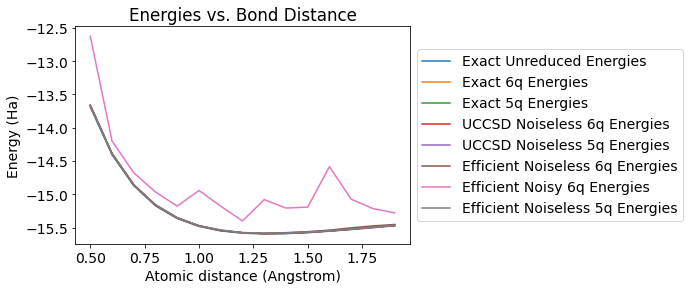

In [34]:
plt.plot(distances, exact_unreduced_energies, label="Exact Unreduced Energies")
plt.plot(distances, expected_6q_energies, label="Exact 6q Energies")
plt.plot(distances, exact_reduced_energies, label="Exact 5q Energies")
plt.plot(distances, uccsd_6q_energies, label="UCCSD Noiseless 6q Energies")
plt.plot(distances, uccsd_reduced_energies, label="UCCSD Noiseless 5q Energies")
plt.plot(distances, vqe_efficient_6q_energies, label="Efficient Noiseless 6q Energies")
plt.plot(distances, vqe_noisy_em_6q_energies, label="Efficient Noisy 6q Energies")
plt.plot(distances, vqe_energies, label="Efficient Noiseless 5q Energies")
plt.title("Energies vs. Bond Distance")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Ha)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

As seen in the above plot, we have performed the VQE for varying atomic distances in the molecular geometry we specify. We infer that the lowest ground state energy for this molecule is for the distance of approximately 1.31 Angstrom. These energies are too close to compare in this plot, necessitating the plot below of the difference:

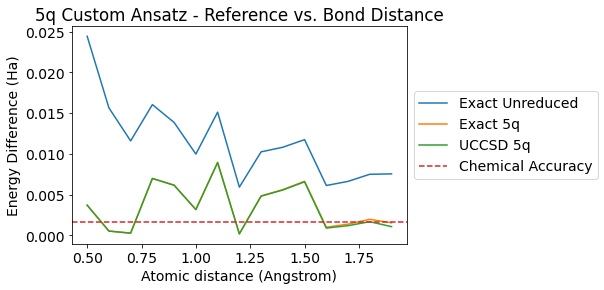

In [42]:
plt.plot(distances, [np.abs(vqe_energies[i] - exact_unreduced_energies[i]) for i in range(len(vqe_energies))], label="Exact Unreduced")
plt.plot(distances, [np.abs(vqe_energies[i] - exact_reduced_energies[i]) for i in range(len(vqe_energies))], label="Exact 5q")
plt.plot(distances, [np.abs(vqe_energies[i] - uccsd_reduced_energies[i]) for i in range(len(vqe_energies))], label="UCCSD 5q")
plt.axhline(y=.0016, color="tab:red", ls="--", label="Chemical Accuracy")
plt.title("5q Custom Ansatz - Reference vs. Bond Distance")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy Difference (Ha)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

As we can see from the plot above, the 5-qubit VQE is within the range of chemical accuracy for around half of the bond distances when comparing to the exact eigen energy solver, and the full UCCSD solver for the 5 qubit model. It is also on average within one hundreth of a Ha for the exact unreduced eigen energy.

Additionally, the results seem to improve by the increasing bond distance.

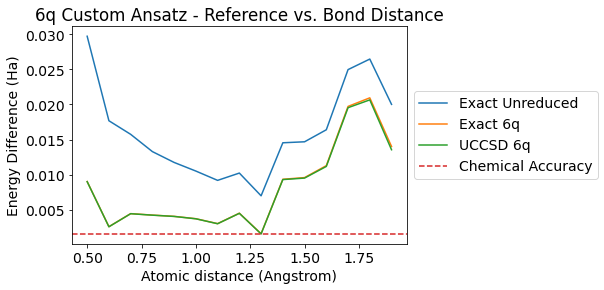

In [43]:
plt.plot(distances, [np.abs(vqe_efficient_6q_energies[i] - exact_unreduced_energies[i]) for i in range(len(vqe_energies))], label="Exact Unreduced")
plt.plot(distances, [np.abs(vqe_efficient_6q_energies[i] - expected_6q_energies[i]) for i in range(len(vqe_energies))], label="Exact 6q")
plt.plot(distances, [np.abs(vqe_efficient_6q_energies[i] - uccsd_6q_energies[i]) for i in range(len(vqe_energies))], label="UCCSD 6q")
plt.axhline(y=.0016, color="tab:red", ls="--", label="Chemical Accuracy")
plt.title("6q Custom Ansatz - Reference vs. Bond Distance")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy Difference (Ha)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The plot above is a similar plot as the 5-qubit VQE one above this, but we can see it is slightly less accurate on average compared to the exact eigen energy of the unreduced model, and even compared to the other 6-qubit models.

This finding suggests that the 5-qubit representation that we found is a more accurate depiction of the molecule BeH2 and specifically its eigen energies.

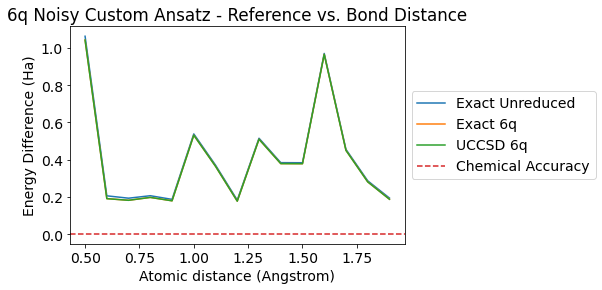

In [44]:
plt.plot(distances, [np.abs(vqe_noisy_em_6q_energies[i] - exact_unreduced_energies[i]) for i in range(len(vqe_energies))], label="Exact Unreduced")
plt.plot(distances, [np.abs(vqe_noisy_em_6q_energies[i] - expected_6q_energies[i]) for i in range(len(vqe_energies))], label="Exact 6q")
plt.plot(distances, [np.abs(vqe_noisy_em_6q_energies[i] - uccsd_6q_energies[i]) for i in range(len(vqe_energies))], label="UCCSD 6q")
plt.axhline(y=.0016, color="tab:red", ls="--", label="Chemical Accuracy")
plt.title("6q Noisy Custom Ansatz - Reference vs. Bond Distance")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy Difference (Ha)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

As seen in the above plot, we have compared the Noisy VQE result for 6 qubits to the full noiseless VQE on 6 qubits, the exact eigen energy on 6 qubits, and the exact eigen energy on the unreduced model (14 qubits). 

Obviously, due to the noise, even with error mitigation (resilience set to 2), we were only able to get within ~.2 Ha of the expected energies, which is an order of 10-100x worse than that of the noiseless simulator. 

The reason why all the lines are on top of each other is because the noisy backend accuracy is much further from the reference values than they are from each other.

There are other resilience methods we did not have time to try that could have aleviated this, like the incorporation of mitiq and trying this with the 5-qubit model, but that will be left to future work.

## Future Work

Future work on this project is planned, such as running this VQE on the IBM Guadalupe QPU. We were not able to run on a real QPU thus far. Running on the fake Guadalupe backend which includes a noise model and the connectivity constraints of the real QPU was found to run significantly slower than the noiseless simulator, especially when including circuit optimization and error mitigation protocols. We believe the small number of qubits used in our BeH2 model for the noiseless simulation would be a good target for testing on noisy backends in the NISQ era.


We also want to further analyze the relationship between atomic distance of our model and accuracy of the VQE, which we have begun above. 

Below are additional results and analysis for this project:

6 qubit model GuadalupeV2 fake noisy backend. Bond distance 1.7A. Error mitigation level 3. Optimization level 3. 100K shots.

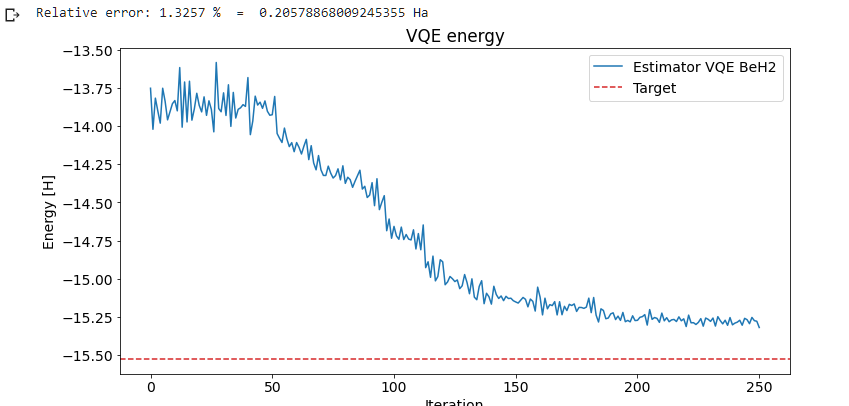

We ran the 6 qubit model on the fake GuadalupeV2 noisy backend. Chemical accuracy was not achieved, however we were limited in the number of iterations due to constraints on the classical computing power of our laptops.

We believe this is a good proof of concept to run the 5  and 6 qubit models on the real guadalupe backend from IBM.